In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
from helper import revert_diff
import pmdarima as pmd
import pandas_datareader.data as web
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

sns.set_theme()
mpl.rcParams['figure.figsize'] = (10, 7)
mpl.rcParams["figure.dpi"] = 100

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Introduction to Time-Series Modelling and Forecasting

# What is a linear regression?

## Simple linear regression

We observe the values $(x_1, x_2, x_3, ..., x_n)$ (predictors) and assume the following linear relationship between $X$ and $Y$:
$$ Y = \beta_0 + \beta_1X + \epsilon$$

Where $\epsilon$ is an error term, $\epsilon \sim N(0,1)$

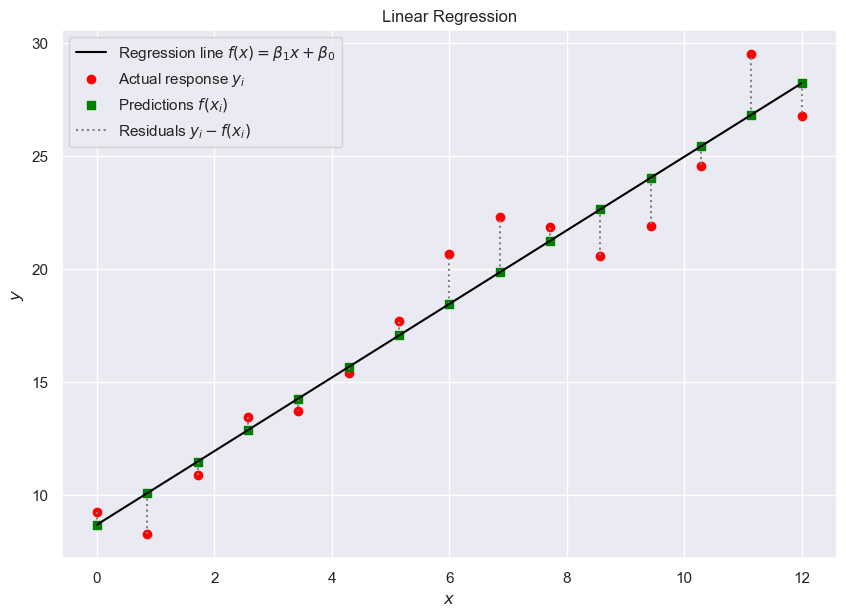

In [2]:
# Simple linear regression
x = np.linspace(0, 12, 15)
error = norm.rvs(size=len(x), scale=2)
y = 10 + 1.5 * x + error

model = sm.OLS(y, sm.add_constant(x))
model_fit = model.fit()

fitted = model_fit.fittedvalues
fig, ax = plt.subplots()
ax.scatter(x, y, label="Actual response $y_i$", color="red")
ax.scatter(x, fitted, label="Predictions $f(x_i)$", marker="s", color="green")
ax.plot(x, fitted, color="black", label="Regression line $f(x) = \\beta_1x + \\beta_0$")
ax.vlines(x, fitted, y, color="grey", linestyle="dotted", 
    label="Residuals $y_i - f(x_i)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Linear Regression")
ax.legend()
plt.show()

The simple linear regression model can be easily extend to a a multiple linear regression model where we have more than one predictor variable.

## Multiple linear regression

There are $p$ predictor variables $X_1, X_2, \ldots, X_p$ and we assume the following model:
$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_p X_p + \epsilon$$

Where $\epsilon \sim N(0,1)$. 

## Key assumptions:
- **Linearity**: The relationship between $X$ and $Y$ is linear.
- **Homoscedasticity**: The variance of residual is the same for any value of $X$.
- **Independence**: The residual terms are independent of each other.
- **Normality**: The residuals are normally distributed with mean 0.

# How to asses model fit?

## Diagnostic plots

To check if the model fits well and the assumptions of normality and homoscedasticity hold it is helpful to look at the plot of residuals vs. fitted values. Let's look at the following examples where we assume the simple linear model $Y = \beta_0 + \beta_1X + \epsilon$

1. $Y = 10 + 5X + \epsilon$, good model
2. $Y = 10 + 1.5X + 2X^2 + \epsilon$, bad model, clear relationship
3. $Y = 10 + X + \epsilon \cdot X$, heterosceadastcity

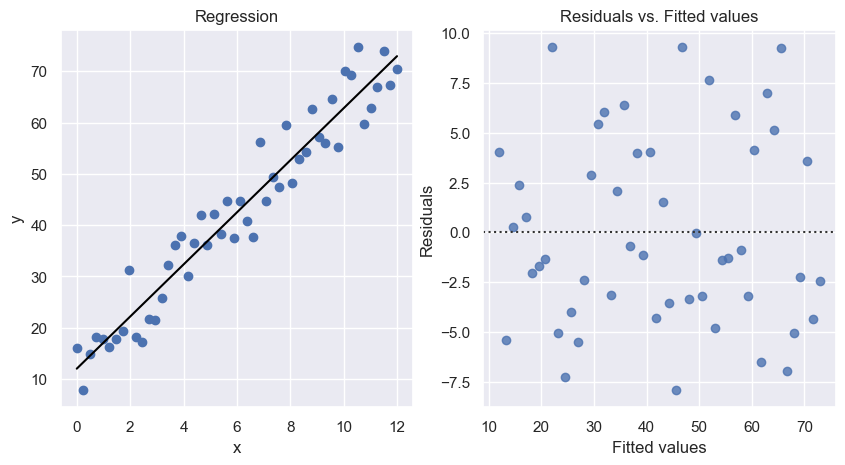

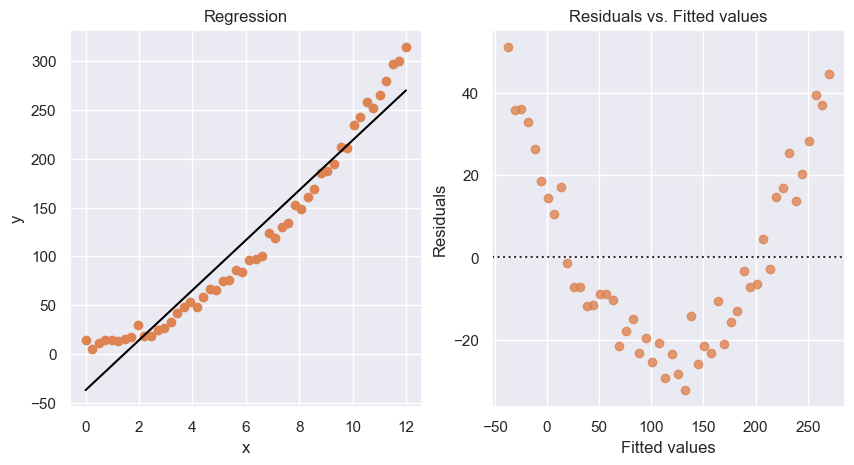

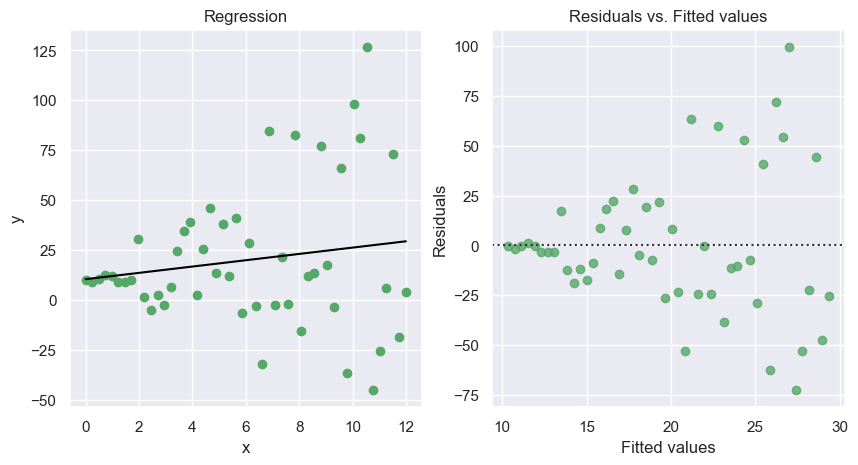

In [3]:
def plot_residuals(fitted, resid, ax, **args):
    sns.residplot(ax=ax, x=fitted, y=resid, **args)
    ax.set_title("Residuals vs. Fitted values")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    return ax

def plot_regression_scatter(mod, x, y, ax, **args):
    ax.plot(x, mod.predict(sm.add_constant(x)), color='black')
    ax.scatter(x, y, **args)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Regression")
    return ax

# Residuals vs. Fitted
x = np.linspace(0, 12, 50)
error = norm.rvs(size=len(x), scale=5)
y = [None]*3
y[0] = 10 + 5 * x + 2 + error  # good example
y[1] = 10 + 1.5 * x + 2*x**2 + error  # quadratic relationship
y[2] = 10 + x + error * x  # heteroscedasticity

mods = [sm.OLS(y[i], sm.add_constant(x)).fit() for i in range(3)]

for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    plot_regression_scatter(mods[i], x, y[i], ax=ax[0], color="C" + str(i))
    plot_residuals(mods[i].fittedvalues, mods[i].resid, ax=ax[1], color="C" + str(i))
    plt.show()

## Model Fit statistics

### Coefficient of determination R^2 

$R^2$ is a statistic that will give some information about the goodness of fit of a model. It is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). An $R^2$ of 1 indicates that the regression predictions perfectly fit the data.

$$R^2 = \frac{\text{RegrSS}}{\text{TotalSS}}=  1 - \frac{\text{ResidSS}}{\text{TotalSS}}$$

$$\text{TotalSS} = \sum_i(y_i - \bar{y})^2$$
$$\text{ResidSS} = \sum_i(y_i - f_i)^2$$
$$\text{RegrSS} = \sum_i(f_i - \bar{y})^2$$

In [4]:
for i in range(3):
    print("R-squared of model %s : %f" % (i + 1, mods[i].rsquared))

R-squared of model 1 : 0.935175
R-squared of model 2 : 0.941983
R-squared of model 3 : 0.025487


# Regression meets Time Series

Suppose we observe the values $y_1, \ldots, y_t$ sequentially in time. In this scenerio this is the only data that we have, there are no other "predictor" variables. Can we say something about the value of $y_{t+1}$ given all the past observations $y_1, \ldots, y_n$?

## Autoregressive model - AR(p)
The autoregressive model specifies that the output variable depends linearly on its own previous values: 

$$ Y_t =  \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \ldots + \beta_pY_{t-p} + \epsilon_t$$

Where $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0,1)$ is a white noise sequence.

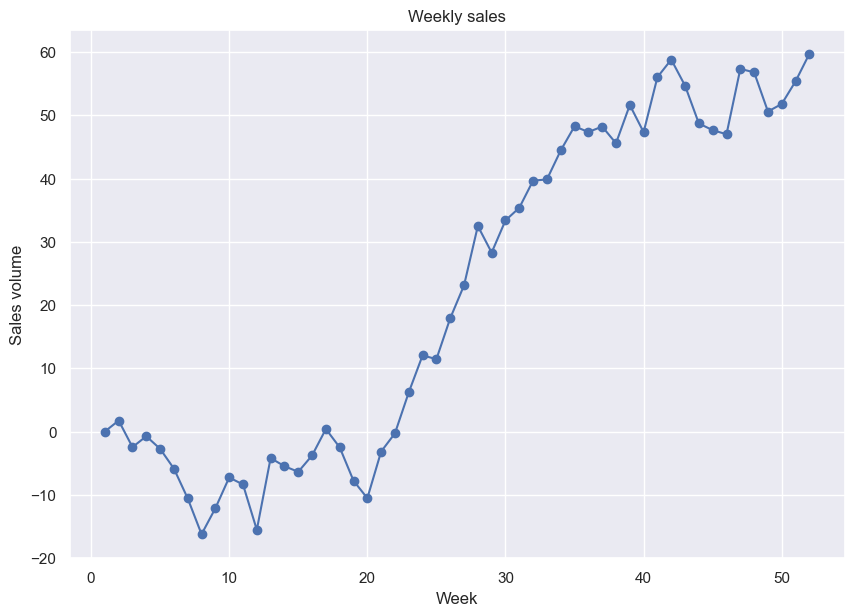

In [5]:
# AR(1) example
sales_df = pd.read_csv("data/weekly-sales.csv")

fig, ax = plt.subplots()
ax.plot(sales_df["week"], sales_df["volume"])
ax.scatter(sales_df["week"], sales_df["volume"])
ax.set_title("Weekly sales")
ax.set_xlabel("Week")
ax.set_ylabel("Sales volume")
plt.show()

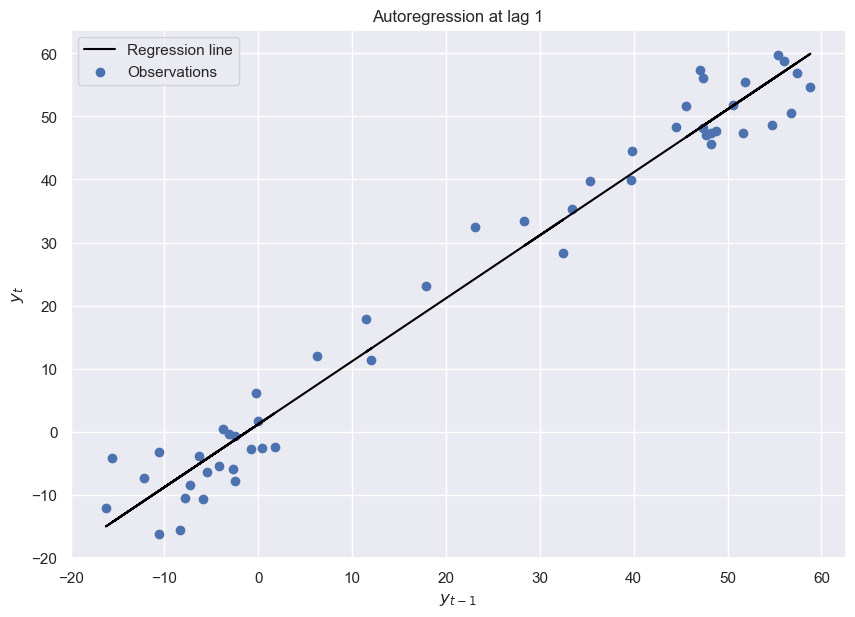

R-squared: 0.969


In [6]:
y_prev = sales_df["volume"].shift(1)[1:]
y_next = sales_df["volume"][1:]

model = sm.OLS(y_next, sm.add_constant(y_prev)).fit()

fig, ax = plt.subplots()
ax.plot(y_prev, model.predict(sm.add_constant(y_prev)), 
    color="black", label="Regression line")
ax.scatter(y_prev, y_next, label = "Observations")
ax.set_title("Autoregression at lag 1")
ax.set_xlabel("$y_{t-1}$")
ax.set_ylabel("$y_{t}$")
ax.legend()
plt.show()

print("R-squared:", round(model.rsquared, 3))

# Moving Average Model - MA(q)

The moving-average model specifies that the output variable depends linearly on the current and past values of the white noise terms:

$$Y_t = \mu + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \ldots + \theta_q\epsilon_{t-q} + \epsilon_t$$

Where $\mu$ is the mean of the series and $\epsilon_t$ a white noise terms.

Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model. We do not observe the values of  
$\epsilon_t$, so it **is not** really a regression in the usual sense.

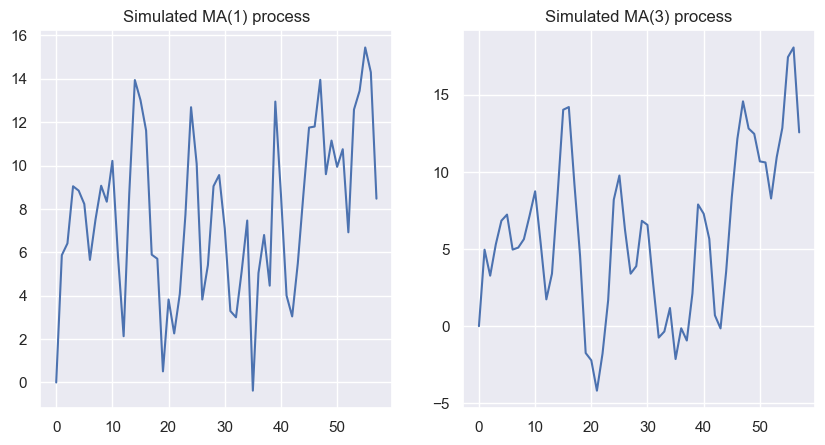

In [7]:
# Example moving average series
N = 60
errors = norm.rvs(size=N, scale=2)
y1 = np.zeros(N)  # MA(1)
y3 = np.zeros(N)  # MA(3)
mu = 10
for t in range(3, N):
    y1[t] = mu + 2*errors[t - 1] + errors[t]
    y3[t] = mu + 1 * errors[t - 3] + 1.5*errors[t - 2] + 2*errors[t - 1] + errors[t]

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(y1[2:])
ax[0].set_title("Simulated MA(1) process")

ax[1].plot(y3[2:])
ax[1].set_title("Simulated MA(3) process")

plt.show()

# AR(p) and MA(q) Model Assumptions

When workting with AR(p) and MA(q) models we assume that the time series $Y_t$ is **(weakly) stationary** i.e.
- The mean $\mathbb{E}(Y_t) = \mu$ is constant for all $t$
- The variance $Var(Y_t)$ is the same for all $t$
- The covariance $Var(Y_t, Y_{t-k}) = \rho_k$ is the same for each lag $k$

In practice, this means that no trend or seasonality is present in our time series. We will deal with those later.
See below examples of stationary and non-stationary time series.

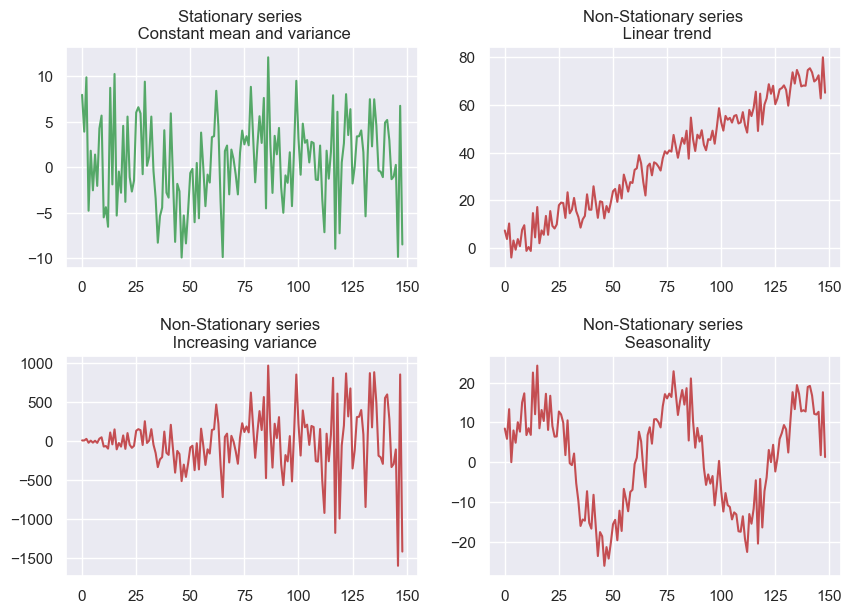

In [8]:
N = 150
errors = norm.rvs(size=N, scale=5 )
mu = 1
y = np.zeros((N, 4))
for t in range(1, N):
    y[t][0] = mu + errors[t] # Stationary time series
    y[t][1] = t / 2 + errors[t] # Linear trend
    y[t][2] = mu + t * errors[t] # Increasing varianve
    y[t][3] = 15 * np.sin(t / 10) + errors[t] # Seasonality

fig, ax = plt.subplots(2, 2)
ax[0][0].plot(y[1:, 0], color="C2")
ax[0][0].set_title("Stationary series \n Constant mean and variance")

ax[0][1].plot(y[1:, 1], color="C3")
ax[0][1].set_title("Non-Stationary series \n Linear trend")

ax[1][0].plot(y[1:, 2], color="C3")
ax[1][0].set_title("Non-Stationary series \n Increasing variance")

ax[1][1].plot(y[1:, 3], color="C3")
ax[1][1].set_title("Non-Stationary series \n Seasonality")
plt.subplots_adjust(hspace=0.4)

## How to recognise AR(p) and MA(q) processes ?

#### Autocorrelation ACF

$$\text{ACF}_k = Corr(Y_t, Y_{t-k})$$

**MA(p):** Autocorrelations are zero for lag $k > p$

#### Parital Autocorrelation PACF

$$\text{PACF}_k = Corr(Y_t, Y_{t-k} \ | \ Y_{t-1}, \ldots, Y_{t-k+1})$$

**AR(p):** Partialautocorrelations are zero for lag $k > p$


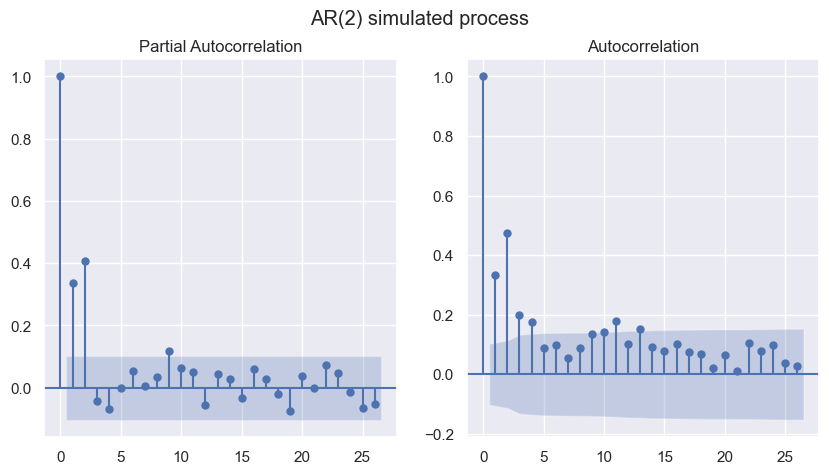

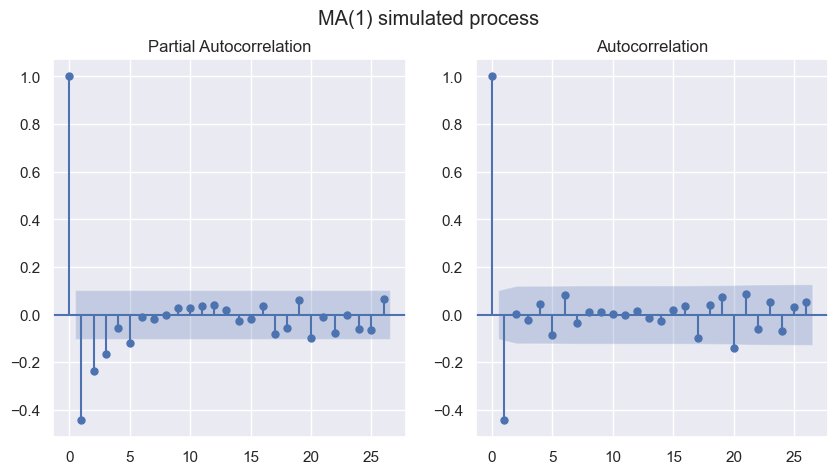

In [9]:
def plot_acf_pacf(y, title=None, **kwargs):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sm.graphics.tsa.plot_pacf(y, ax=ax[0], method="ywm", **kwargs)
    sm.graphics.tsa.plot_acf(y, ax=ax[1], **kwargs)
    if title:
        fig.suptitle(title)
    plt.show()

N = 365
np.random.seed(3)
ar2 = sm.tsa.arma_generate_sample([1, -0.2, -0.4], [1], nsample=N, scale=1) #AR(2)
ma1 = sm.tsa.arma_generate_sample([1], [1, -0.6], nsample=N, scale=1) #MA(1)

plot_acf_pacf(ar2, "AR(2) simulated process")
plot_acf_pacf(ma1, "MA(1) simulated process")


# What to do if the series is not stationary?

## Differencing - solution for removing trend and seasonality.

Suppose that $Y_t$ is a time series with a linear trend, i.e.:

$$Y_t = \mu + \alpha t + Z_t$$

Where $Z_t$ is a stationary process. Instead of modelling $Y_t$ we can look at 
$$\tilde{Y_t} = Y_t - Y_{t-1} = \alpha + Z_t - Z_{t-1}$$ 
Then $\tilde{Y_t}$ is a stationary time series.

To remove a quadratic trend we can differentiate the series twice

If a sesonal effect of length $m$ is present, e.g. 12-month cycle, weekly cycle etc. we should consider a series differenced at lag m
$$\tilde{Y_t} = Y_t - Y_{t-m}$$ 

**Note:** The order of difference operations does not matter.

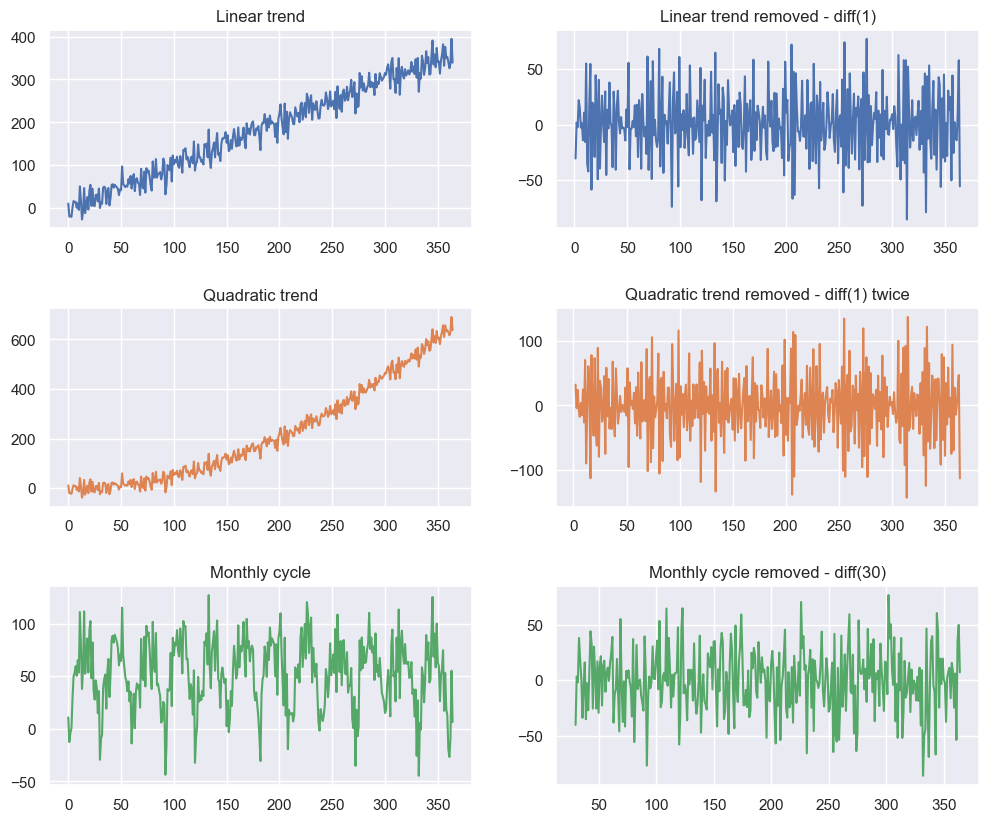

In [10]:
# Generate series
N = 365
errors = norm.rvs(size=N, scale=20)
y1 = np.arange(N) + errors  # linear trend
y2 = 0.005 * np.power(np.arange(N), 2) + errors  # quadratic trend
y3 = np.sin(np.arange(0, 365) % 30 / 10) * 80 + errors  # monthly cycle

# Apply diferencing
x1 = pd.Series(y1).diff()
x2 = pd.Series(y2).diff().diff()
x3 = pd.Series(y3).diff(30)


fig, ax = plt.subplots(3, 2, figsize=(12, 10))
# Plot original series
ax[0][0].plot(y1, color="C0")
ax[0][0].set_title("Linear trend")
ax[1][0].plot(y2, color="C1")
ax[1][0].set_title("Quadratic trend")
ax[2][0].plot(y3, color="C2")
ax[2][0].set_title("Monthly cycle")

# Plot differenced series
ax[0][1].plot(x1, color="C0")
ax[0][1].set_title("Linear trend removed - diff(1)")
ax[1][1].plot(x2, color="C1")
ax[1][1].set_title("Quadratic trend removed - diff(1) twice")
ax[2][1].plot(x3, color="C2")
ax[2][1].set_title("Monthly cycle removed - diff(30)")
plt.subplots_adjust(hspace=0.4)
plt.show()

# Time for the fusion 
## AR + I + MA = ARIMA:  Autoregressive Integrated Moving Average Model

ARIMA model captures all the aproaches presented so far:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of $\text{ARIMA}(p,d,q)$.

 - $p$ is the order (number of time lags) of the autoregressive model
 - $d$ is the degree of differencing (the number of times the data have had past values subtracted)
 - $q$ is the order of the moving-average model.

 $$Y_t = \mu + \beta_1Y_{t-1} + \ldots + \beta_pY_{t-p} + \theta_1\epsilon_{t-1} + \ldots + \theta_q\epsilon_{t-q} + \epsilon_t$$


# Modelling procedure with ARIMA

1. Plot the data, identify unusual observations
2. If necerssary, transform the series to stabilise the variance
3. Select the model:
    - If necessary difference the series to remove trend and seasonality
    - Plot the ACF/PACF to and try to determine the candidate models
    - Try the chosen models and compare fit statistics to choose the best one

    OR
    
    - Use automatic selection algorithms to find the best fitting ARIMA model
4. Check the residuals
5. Calculate the forecasts

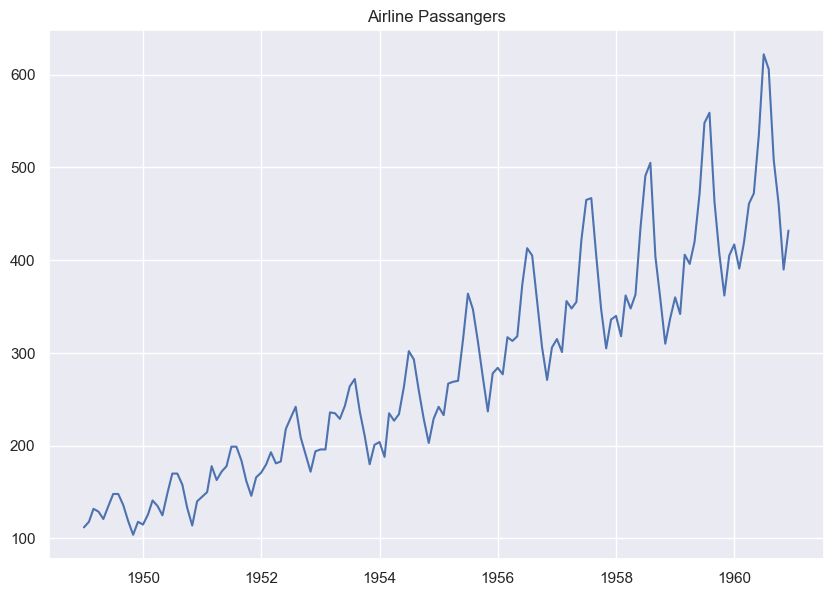

In [11]:
df= pd.read_csv("data/airpassangers.csv", parse_dates=True, index_col=0)
df.columns = ["passangers"]
plt.plot(df["passangers"])
plt.title("Airline Passangers")
plt.show()

Text(0.5, 1.0, 'Log-transformed Airline Passangers')

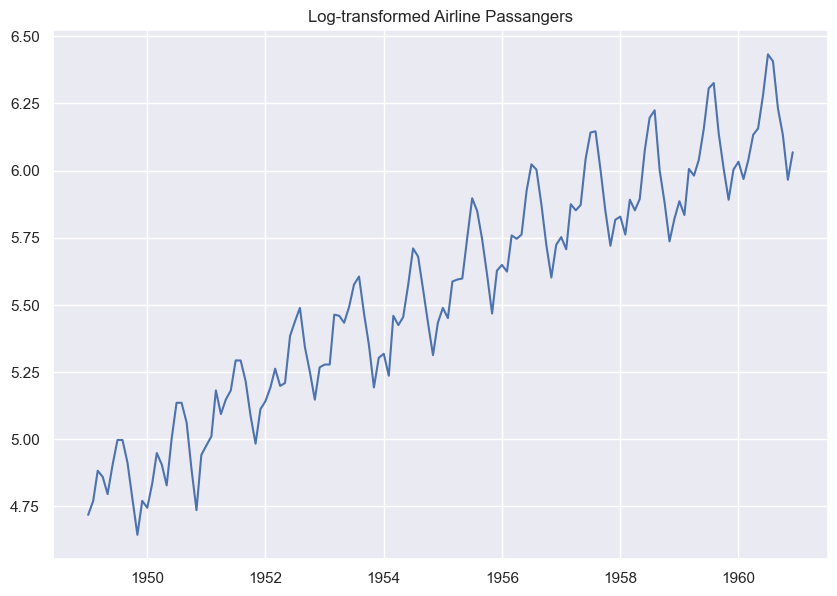

In [12]:
plt.plot(np.log(df["passangers"]))
plt.title("Log-transformed Airline Passangers")

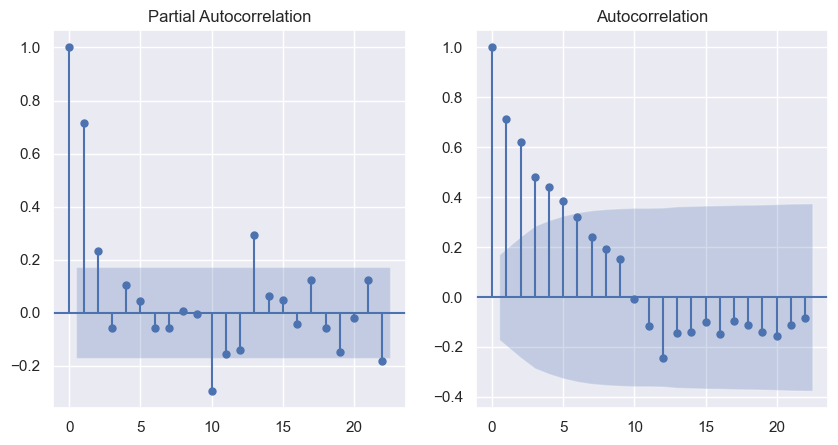

In [13]:
log_passangers = np.log(df["passangers"])
y = log_passangers.diff(12)[12:]
plot_acf_pacf(y)

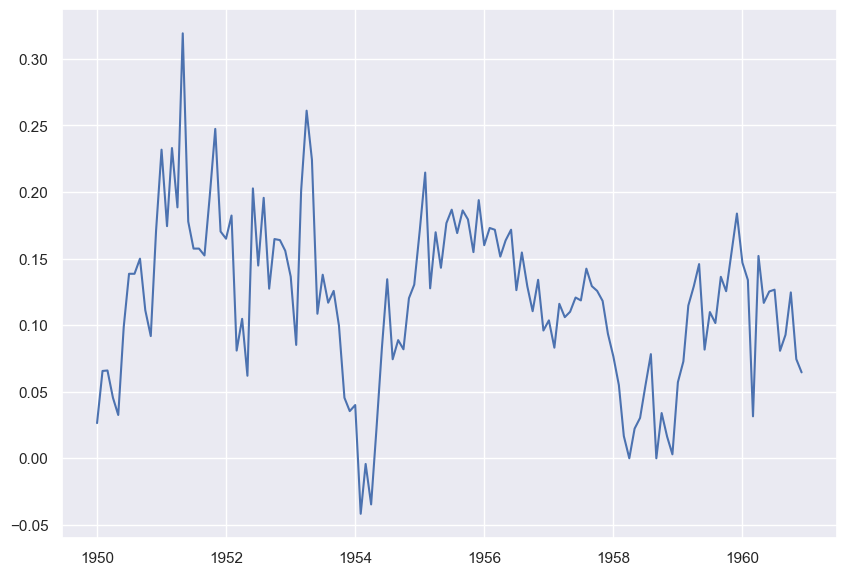

In [14]:
plt.plot(y)

In [15]:
# Fit the selected model based on PACF and ACF
model_fit = ARIMA(y, order=(2, 0, 0)).fit()
results = model_fit.get_prediction()
conf_int = results.conf_int(alpha=0.05).values
fitted = results.predicted_mean
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passangers   No. Observations:                  132
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 233.131
Date:                Thu, 20 Jan 2022   AIC                           -458.262
Time:                        13:29:17   BIC                           -446.731
Sample:                    01-01-1950   HQIC                          -453.577
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1150      0.017      6.926      0.000       0.082       0.148
ar.L1          0.5540      0.074      7.515      0.000       0.410       0.698
ar.L2          0.2378      0.073      3.252      0.001       0.095       0.381
sigma2         0.0017      0.000      9.762      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.78
Prob(Q):                              0.94   Prob(JB):                         0.02
Heteroskedasticity (H):               0.40   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Compare with the auto_arima
auto_model = pmd.auto_arima(y, trace=True, stepwise=False)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-358.005, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-406.130, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-440.803, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-446.599, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-445.907, Time=0.28 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-449.147, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-452.647, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-457.177, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-455.568, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-456.726, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-455.415, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-458.262, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-457.354, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-455.363, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-455.012, Time=0.25 sec
 ARIMA(3,0

/opt/anaconda3/envs/interstellar-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


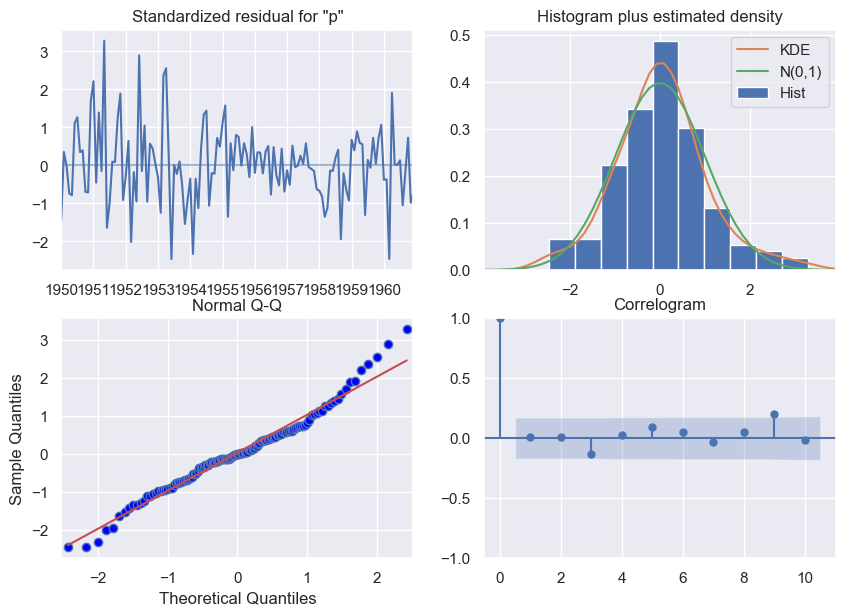

In [17]:
model_fit.plot_diagnostics()
plt.show()

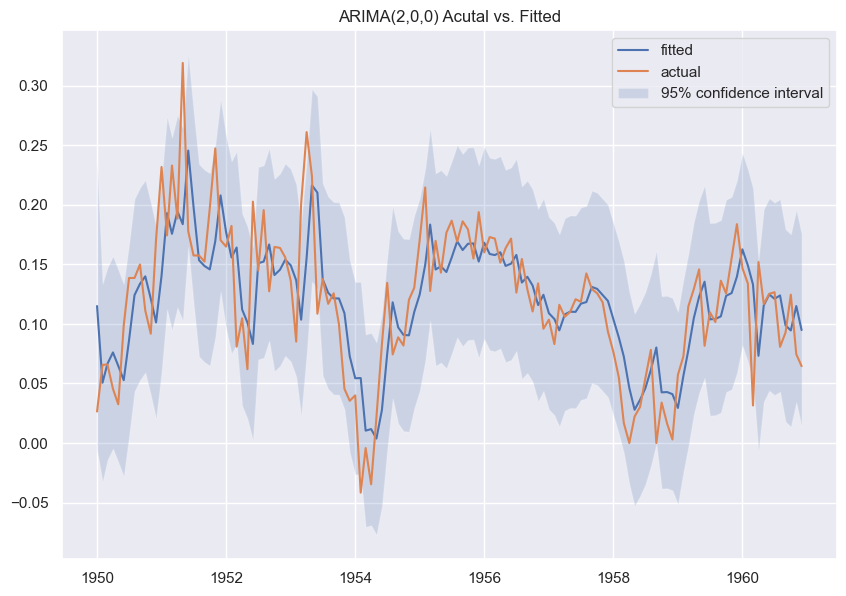

In [18]:
plt.plot(y.index, fitted, label="fitted")
plt.fill_between(y.index, conf_int[:,0], conf_int[:, 1], 
    alpha=0.2, label="95% confidence interval")
plt.plot(y, label="actual")
plt.title("ARIMA(2,0,0) Acutal vs. Fitted")
plt.legend()
plt.show()

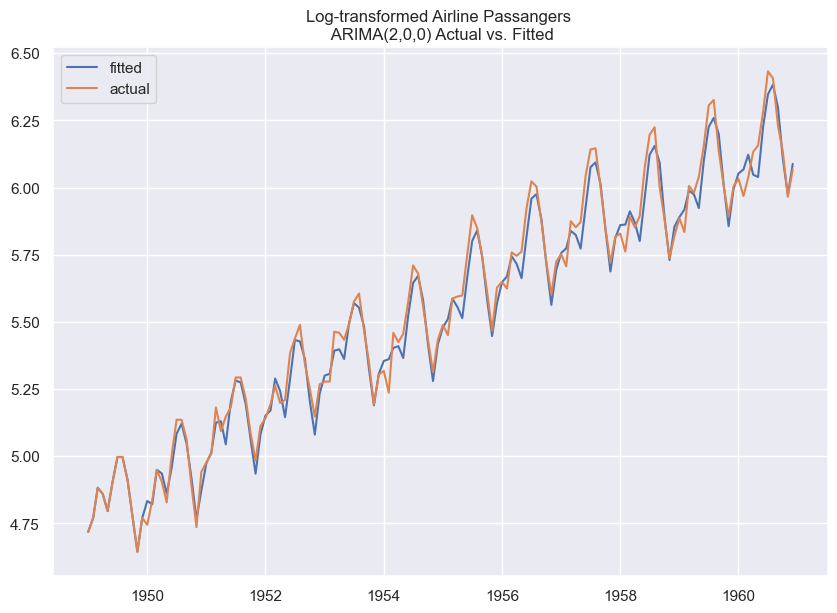

In [19]:
plt.plot(log_passangers.index, revert_diff(fitted, log_passangers[:12], 12), label="fitted")
plt.plot(log_passangers, label="actual")
plt.title("Log-transformed Airline Passangers \n ARIMA(2,0,0) Actual vs. Fitted")
plt.legend()
plt.show()

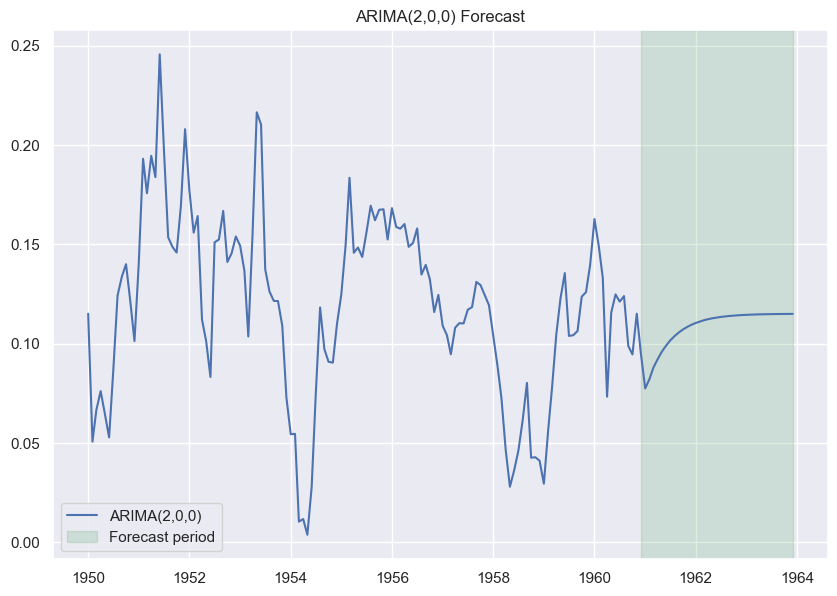

In [20]:
forecast = np.concatenate([fitted, model_fit.forecast(36)])
date_index = pd.date_range(fitted.index[0], periods=len(fitted)+36, freq='MS')
plt.plot(date_index, forecast, label="ARIMA(2,0,0)")
plt.axvspan(fitted.index[-1], date_index[-1], alpha=0.2, color='C2', label="Forecast period")
plt.title("ARIMA(2,0,0) Forecast")
plt.legend()
plt.show()

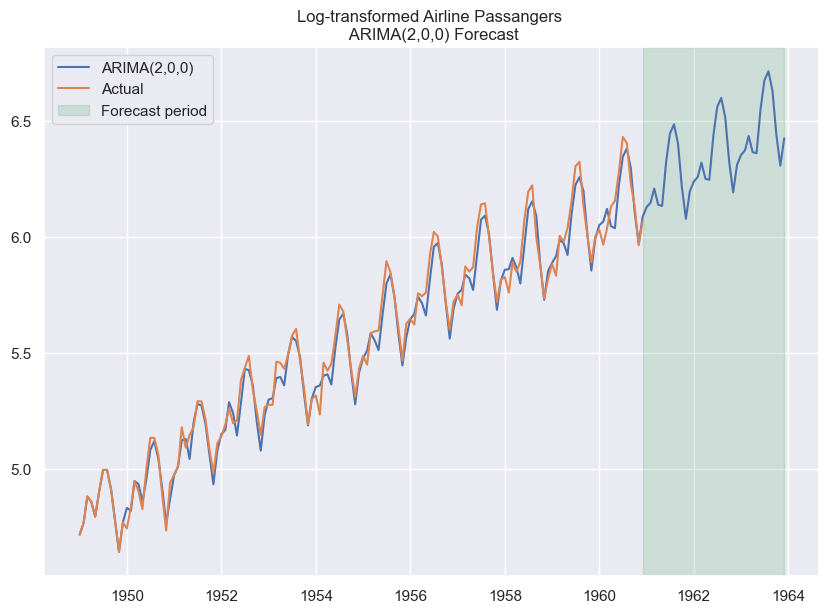

In [21]:
date_index = pd.date_range(log_passangers.index[0], periods=len(fitted)+36+12, freq='MS')
plt.plot(date_index, revert_diff(forecast, log_passangers[:12], 12), label="ARIMA(2,0,0)")
plt.plot(log_passangers, label="Actual")
plt.axvspan(fitted.index[-1], date_index[-1], alpha=0.2, color='C2', label="Forecast period")
plt.title("Log-transformed Airline Passangers \n ARIMA(2,0,0) Forecast")
plt.legend()
plt.show()

# Time to Practice: Algorithmic Trading

Its now time to practice and test what we've learnt in time series modelling by developing a couple of algorithmic trading strategies! Our plan of action will be:

1. Fetch, clean, and transform our financial time series data 
2. Use our ARIMA modelling skills to forecast stock returns
3. Implement and backtest simple trading rules to analyse their performance


# Fetching our data



In [22]:
# Retrieving stock price data 
stocks = ['GOOG', 'AAPL', 'FB', 'AMZN', 'GE', 'NFLX', 'JPM']
          
data = web.DataReader(stocks, 'yahoo', start='2020/11/10', end='2021/11/10')
data.head()

Attributes    Adj Close                                                  \
Symbols            GOOG        AAPL          FB         AMZN         GE   
Date                                                                      
2020-11-10  1740.390015  115.259453  272.429993  3035.020020  71.548210   
2020-11-11  1752.709961  118.757881  276.480011  3137.389893  70.831139   
2020-11-12  1749.839966  118.479599  275.079987  3110.280029  69.795357   
2020-11-13  1777.020020  118.529289  276.950012  3128.810059  73.699432   
2020-11-16  1781.380005  119.562920  278.959991  3131.060059  76.249039   

Attributes                                Close                          ...  \
Symbols           NFLX         JPM         GOOG        AAPL          FB  ...   
Date                                                                     ...   
2020-11-10  480.239990  112.988335  1740.390015  115.970001  272.429993  ...   
2020-11-11  490.760010  111.301071  1752.709961  119.489998  276.480011  ...   
2020-11-12  486.769989  109.933807  1749.839966  119.209999  275.079987  ...   
2020-11-13  482.839996  110.622292  1777.020020  119.260002  276.950012  ...   
2020-11-16  479.100006  113.744690  1781.380005  120.300003  278.959991  ...   

Attributes       Open                             Volume               \
Symbols            GE        NFLX         JPM       GOOG         AAPL   
Date                                                                    
2020-11-10  70.559998  470.950012  117.349998  2636100.0  138023400.0   
2020-11-11  72.879997  483.000000  116.889999  1264000.0  112295000.0   
2020-11-12  70.080002  491.000000  112.529999  1247500.0  103162300.0   
2020-11-13  70.879997  486.769989  114.699997  1499900.0   81581900.0   
2020-11-16  76.879997  480.000000  117.790001  1246800.0   91183000.0   

Attributes                                                            
Symbols             FB       AMZN          GE       NFLX         JPM  
Date                                                                  
2020-11-10  29067700.0  6591000.0  20591700.0  8306100.0  20539300.0  
2020-11-11  14957000.0  4366900.0  10930000.0  5460500.0  14443400.0  
2020-11-12  12899500.0  4362000.0   9939800.0  5063700.0  22063000.0  
2020-11-13  10391200.0  3756200.0  16247538.0  3002700.0  11847900.0  
2020-11-16  12970400.0  3808700.0  14846500.0  3953600.0  19858600.0  

[5 rows x 42 columns]

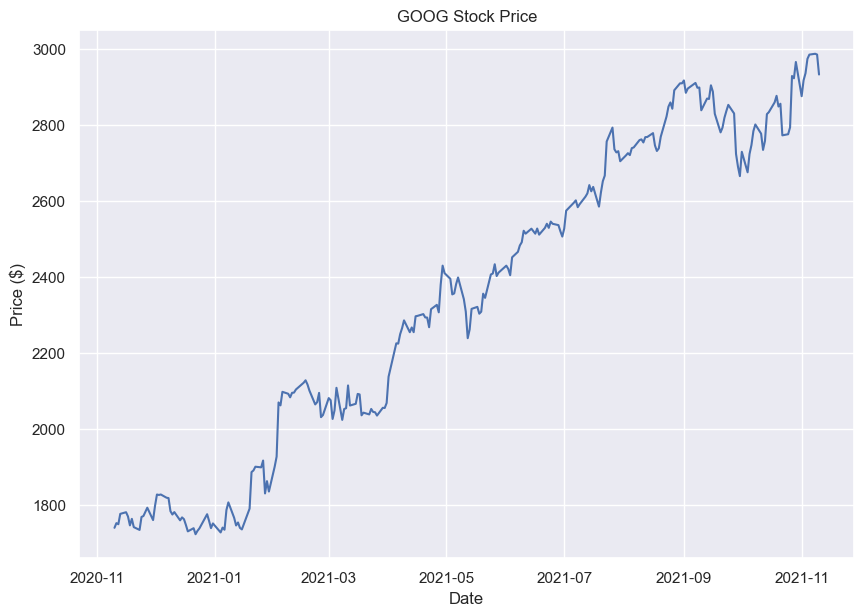

In [23]:
# Select Google closing data
prices = data['Adj Close']['GOOG']

fig, ax = plt.subplots()
ax.plot(prices)
ax.set_title("GOOG Stock Price")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
plt.show()

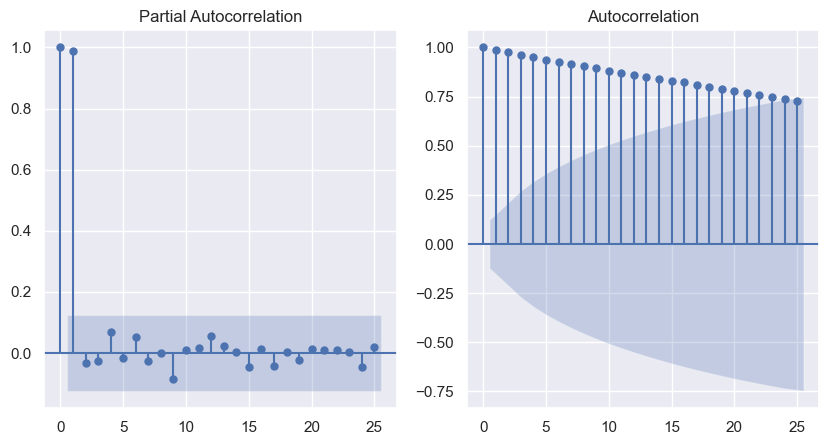

In [24]:
plot_acf_pacf(prices)

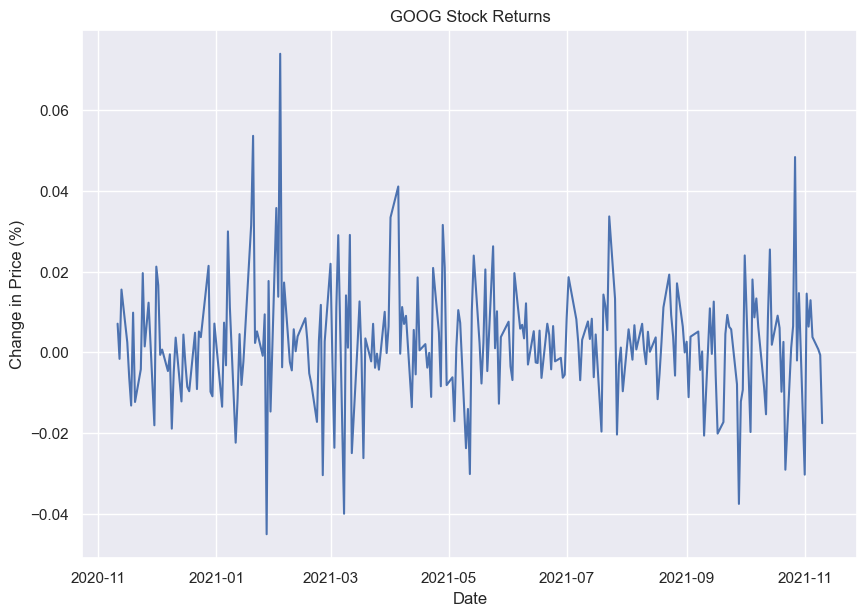

In [25]:
# Get stock returns
returns = prices.pct_change().copy()

fig, ax = plt.subplots()
ax.plot(returns)
ax.set_title("GOOG Stock Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Change in Price (%)")
plt.show()

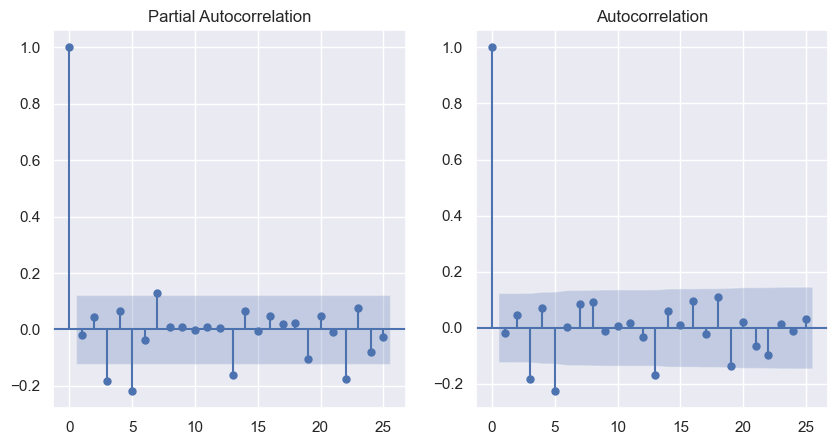

In [26]:
plot_acf_pacf(returns[1:])

# What model do you think is suitable for this stock price?



In [27]:
# Compare with the auto_arima
auto_model = pmd.auto_arima(prices, trace=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2486.445, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2488.413, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2490.090, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2480.029, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2480.935, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2474.599, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2488.410, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2484.228, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2482.952, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2476.532, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2478.451, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2490.041, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2484.107, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2478.396, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2477.968, Time=0.26 sec
 ARIMA(3,1

# Our trading strategy
- Start out with a simple strategy
    - Predict returns $\hat{r}_t$
    - Buy if prediction is above $r^{\text{buy}}$, sell if it is below $r^{\text{sell}}$




In [28]:
def arima_trading_backtest(prices, order, buy_ret=0.01, sell_ret=-0.01, train_size=0.3, verbose=True):
    # Preparing returns data
    p, d, q = order
    returns = prices.pct_change()[1:].copy()
    prices = prices[1:]

    # Train-test split and initial model training
    N = returns.shape[0]
    train = returns.head(round(N*train_size))
    test = returns.tail(N-round(N*train_size))
    model = ARIMA(train, order=(p,d-1,q)).fit()

    # Trading simulation
    holding = False
    balance = 100
    preds = []
    trades = []
    for t in test.index:
        i = prices.index.get_loc(t)
        # Forecast
        pred = model.forecast()[i]
        preds.append(pred)
        # Buying and selling conditions
        trade = False
        if (not holding) and (pred>buy_ret):
            trade = True
            holding = True
            trades.append(('buy', prices.index[i-1]))
            buy_price = prices.iloc[i-1]

        elif holding and (pred<sell_ret):
            trade = True
            holding = False
            sell_price = prices.iloc[i-1]
            profit = (sell_price - buy_price)/buy_price
            trades.append(('sell+' if profit>0 else 'sell-', prices.index[i-1]))
            balance += balance*(profit)

        # Verbose prints
        if trade and verbose:
            if not holding:  
                print(f'Sold @ ${sell_price}, {prices.index[i-1]}')
                print(f'Overall trade gain: {100*profit}%')
            else:   
                print(f'Bought @ ${buy_price}, {prices.index[i-1]}')
            print(f'Predicted return: {pred}')
            print(f'Actual return: {returns[t]}')
            print('')

        # Re-train model    
        model = ARIMA(returns[:t], order=(p,d-1,q)).fit() 

    # Present-value of portfolio if still holding     
    if holding:
        sell_price = prices[t]
        profit = (sell_price - buy_price)/buy_price
        trades.append(('sell+',t) if profit>0 else ('sell-',t))
        balance += balance*(profit)
        
    print(f'Overall Balance: ${balance}')
    return pd.Series(preds, index=test.index), trades

# Trading with a simple ARIMA(1,1,0)



In [29]:
preds, trades = arima_trading_backtest(prices, order=(1,1,0))

Overall Balance: $100


# Trading with an ARIMA(0,1,5)



In [30]:
preds, trades = arima_trading_backtest(prices, order=(0,1,5))

Bought @ $2026.7099609375, 2021-03-03 00:00:00
Predicted return: 0.015555266702368736
Actual return: 0.011042589904069144

Sold @ $2114.77001953125, 2021-03-11 00:00:00
Overall trade gain: 4.344975861914442%
Predicted return: -0.019005985340230704
Actual return: -0.02499094330265028

Bought @ $2061.919921875, 2021-03-12 00:00:00
Predicted return: 0.020868456973440492
Actual return: 0.002216414086158691

Sold @ $2052.9599609375, 2021-03-23 00:00:00
Overall trade gain: -0.43454456414351383%
Predicted return: -0.01081905514804676
Actual return: -0.003848054757065178

Bought @ $2045.06005859375, 2021-03-24 00:00:00
Predicted return: 0.016962418499248448
Actual return: -0.00034232405021339396

Sold @ $2285.8798828125, 2021-04-09 00:00:00
Overall trade gain: 11.775684689883658%
Predicted return: -0.014689711553301442
Actual return: -0.013600821278390018

Bought @ $2293.6298828125, 2021-04-20 00:00:00
Predicted return: 0.011657488425071224
Actual return: -0.00014816852210841613

Sold @ $2356.

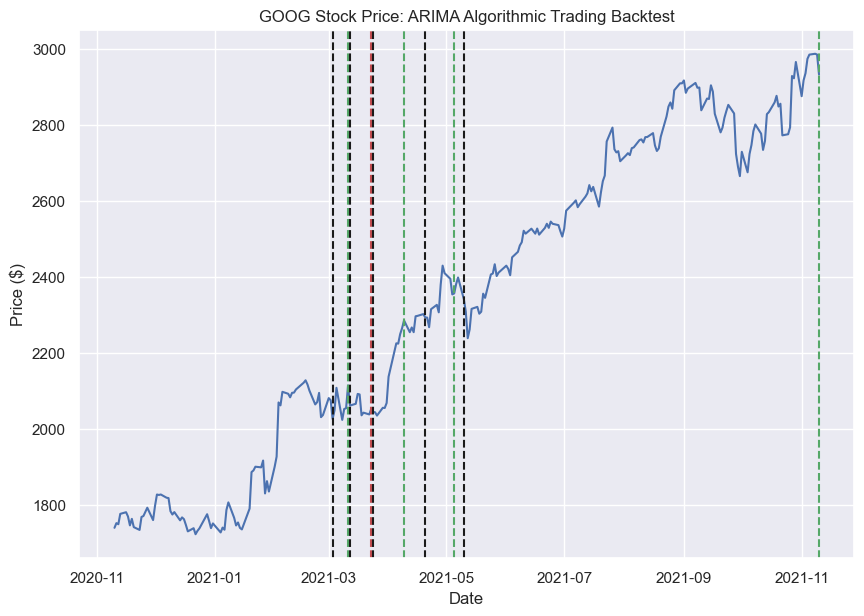

In [31]:
# Plotting prices
fig, ax = plt.subplots()
ax.plot(prices) 
for trade, t in trades:
    plt.axvline(x=t, color= 'g' if trade=='sell+' else 'r' if trade=='sell-' else 'k' , linestyle='--')

ax.set_title("GOOG Stock Price: ARIMA Algorithmic Trading Backtest")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
plt.show()

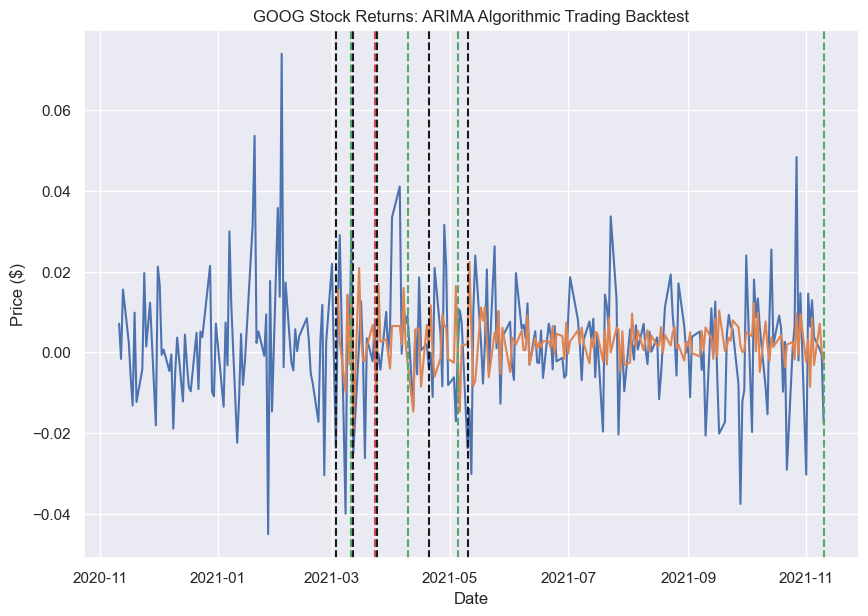

In [32]:
# Plotting prices
fig, ax = plt.subplots()
ax.plot(returns[1:])
ax.plot(preds)
for trade, t in trades:
    plt.axvline(x=t, color= 'g' if trade=='sell+' else 'r' if trade=='sell-' else 'k' , linestyle='--')

ax.set_title("GOOG Stock Returns: ARIMA Algorithmic Trading Backtest")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
plt.show()

# Does our strategy generalize?



In [33]:
for ticker in stocks[1:]:
    prices = data['Adj Close'][ticker] 
    print(ticker)
    arima_trading_backtest(prices, order=(0,1,5), verbose=False)
    print('')

AAPL
Overall Balance: $121.7514522538861

FB
Overall Balance: $114.61629794586187

AMZN
Overall Balance: $115.87520961158486

GE
Overall Balance: $107.85957491974813

NFLX
Overall Balance: $124.23851699225978

JPM
Overall Balance: $100



# What else can we do?
- Complicate the strategy
    - We know when to buy a stock, but how much should we buy?
    - Can we buy more? 
    - Can we short?
- Hyperparameter optimization
    - What are the best buy/sell thresholds? 
    - Try out grid search 
    - Feeling fancy? Give [Bayesian optimization](https://github.com/fmfn/BayesianOptimization) a go!
- Asset classes
    - Which asset classes does the model work best for? 
    - Can you use a different model on each class? What about each asset?
- Confidence is key
    - Can you use other moment estimates to help in your trading?
- Be careful when backtesting
    - Make sure to avoid data leakege and look-ahead bias
    - Careful with overcooking your model
    - Don't forget about transaction costs  
    - Use common sense (sometimes the least common of all)      

